In [ ]:
#phase 1
import pandas as pd
import numpy as np

#phase 2
!pip install category_encoders
from category_encoders import TargetEncoder

#phase 3
!pip install -q sentence-transformers
import re
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

#phase 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("asos_final_clean.csv")
df.head()

,price,sku,description,images,brand,item_category,main_material,fit_type,color_simple
0,49.99,126704571,Coats & Jackets by New Look Low-key layering N...,https://images.asos-media.com/products/new-loo...,New Look,Coats & Jackets,Polyester,Regular,Beige
1,59.99,123650194,Coats & Jackets by Stradivarius Jacket upgrade...,https://images.asos-media.com/products/stradiv...,Stradivarius,Coats & Jackets,Polyester,Regular,Grey
2,45.00,125806824,Coats & Jackets by JDY Low-key layering Notch ...,https://images.asos-media.com/products/jdy-ove...,JDY,Coats & Jackets,Polyester,Oversized,Beige
3,84.95,121963507,Coats & Jackets by Nike Running Hit that new P...,https://images.asos-media.com/products/nike-ru...,Nike Running,Coats & Jackets,Polyester,Regular,Black
4,75.00,123053365,Coats & Jackets by ASOS Tall Throw-on appeal N...,https://images.asos-media.com/products/asos-de...,ASOS Tall,Coats & Jackets,Cotton,Regular,Beige


In [ ]:
len(df)

29971

##Phase 2: Inspect Distinct Values per Column


In [ ]:

# Show number of unique values for every column
unique_counts = df.nunique().sort_values(ascending=False)
print("Unique value counts per column:")
display(unique_counts)


Unique value counts per column:


,0
sku,29971
images,29971
description,28475
brand,4949
price,684
item_category,327
main_material,56
color_simple,14
fit_type,5


While checking for our dataset, we've noticed that there were unique count of product description did not match the entire row count of our dataframe. for confirmation, we ran the below code to find which descriptions came up more than once.

In [ ]:
df['description'].value_counts()[df['description'].value_counts() > 1]

,count
description,
Tops by Topshop Welcome to the next phase of Topshop Plain design Crew neck Short sleeves,16
Tops by Topshop Welcome to the next phase of Topshop High neck Long sleeves,12
Tops by The North Face Exclusive to ASOS Branded design Crew neck Short sleeves,11
Tops by Topshop Welcome to the next phase of Topshop Plain design Crew neck Drop shoulders,10
Trousers & Leggings by Stradivarius Exclusive to ASOS High rise Belt loops Functional pockets,10
...,...
Tops by Converse Your new go-to Crew neck Logo embroidery to chest Regular fit Unisex style,2
T-shirt by COLLUSION Exclusive to ASOS Plain design Crew neck Short sleeves Cropped length,2
Tops by ASOS DESIGN Basket-worthy find High neck Sleeveless style,2


In [ ]:
# Find descriptions that appear more than once
duplicate_desc_values = df['description'].value_counts()
duplicate_desc_values = duplicate_desc_values[duplicate_desc_values > 1].index.tolist()

# Remove ALL rows where the description is one of the duplicated ones
df2 = df[~df['description'].isin(duplicate_desc_values)].copy()

print("Original rows:", len(df))
print("Rows removed due to duplicate descriptions:", len(df) - len(df2))
print("Remaining rows:", len(df2))


Original rows: 29971
Rows removed due to duplicate descriptions: 2661
Remaining rows: 27310


Proceeding to metadata encoding for categorical values

In [ ]:
categorical_cols = ['brand', 'item_category', 'main_material', 'fit_type', 'color_simple']

print("Unique value counts per categorical column:")
for col in categorical_cols:
    print(f"{col}: {df2[col].nunique()}")

Unique value counts per categorical column:
brand: 4811
item_category: 323
main_material: 56
fit_type: 5
color_simple: 14


In [ ]:
# STEP 1: Target Encode the 'brand' column (high cardinality) -
te = TargetEncoder(cols=['brand'])
df2['brand_te'] = te.fit_transform(df2['brand'], df2['price'])

# STEP 2: One-hot encode remaining low-cardinality columns
low_cardinality_cols = ['item_category', 'main_material', 'fit_type', 'color_simple']

df2_encoded = pd.get_dummies(df2, columns=low_cardinality_cols, drop_first=False)

# STEP 3: Build the metadata feature matrix

exclude_cols = ['price', 'sku', 'images', 'description', 'brand']
metadata_cols = [col for col in df2_encoded.columns if col not in exclude_cols]

X_meta = df2_encoded[metadata_cols]
y = df2_encoded['price']


X_meta.head()

,brand_te,item_category_Accessories,item_category_Beach cover-up,item_category_Beach dress,item_category_Beach shirt,item_category_Bikini Bottoms,item_category_Bikini Tops,item_category_Bikini briefs,item_category_Bikini top,item_category_Blazer,...,color_simple_Green,color_simple_Grey,color_simple_Multi/Pattern,color_simple_Orange,color_simple_Other,color_simple_Pink,color_simple_Purple,color_simple_Red,color_simple_White,color_simple_Yellow
0,25.055133,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,29.472625,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,25.461724,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,50.276268,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,37.086971,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


/tmp/ipython-input-4053522054.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


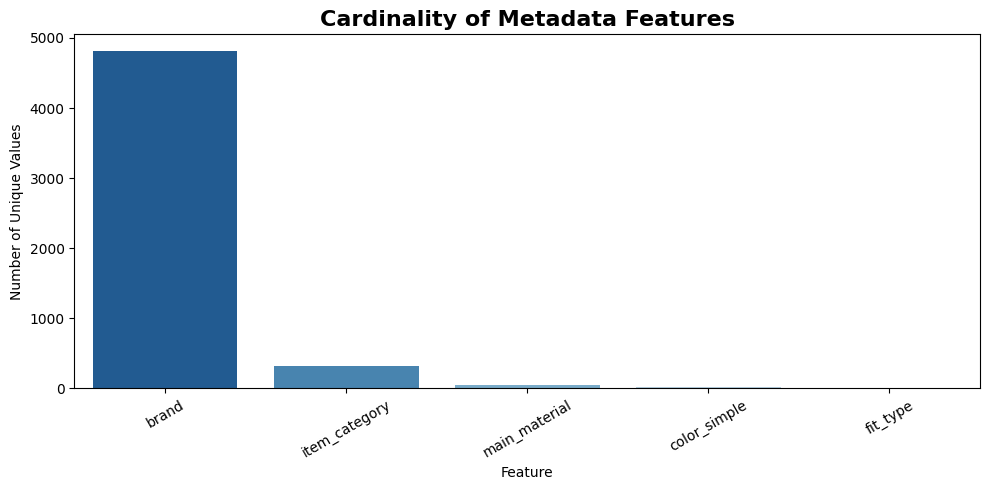

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = ['brand', 'item_category', 'main_material', 'fit_type', 'color_simple']

cardinality = {col: df2[col].nunique() for col in categorical_cols}
cardinality_df = (
    pd.DataFrame.from_dict(cardinality, orient='index', columns=['unique_values'])
    .sort_values('unique_values', ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=cardinality_df,
    x=cardinality_df.index,
    y='unique_values',
    palette='Blues_r'
)

plt.title("Cardinality of Metadata Features", fontsize=16, weight='bold')
plt.xlabel("Feature")
plt.ylabel("Number of Unique Values")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Phase 3 - Text Analytics (BERT/TD-IDF Prep) / Test, train split

In [ ]:
#Step 1  - text cleaning
df3 = df2
df3['description_clean'] = (
    df3['description']
        .str.lower()
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
        .fillna('') # Fill NaN values with empty strings
)

#Step 2 -  Test/train aplit
X_text = df3['description_clean']
y = df3['price']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)


#step 3 - Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=3
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

X_train_tfidf.shape, X_test_tfidf.shape

print("TF-IDF shapes:")
print(X_train_tfidf.shape, X_test_tfidf.shape)

#step 3b - BERT embedding

bert_model = SentenceTransformer('all-MiniLM-L6-v2')

X_train_bert = bert_model.encode(
    X_train_text.tolist(),
    batch_size=32,
    show_progress_bar=True
)

X_test_bert = bert_model.encode(
    X_test_text.tolist(),
    batch_size=32,
    show_progress_bar=True
)

print("BERT shapes:")
print(X_train_bert.shape, X_test_bert.shape)


TF-IDF shapes:
(21848, 10000) (5462, 10000)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/683 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

BERT shapes:
(21848, 384) (5462, 384)


## Phase 4 - Non-Image Baseline Models

In [ ]:

# ---------------------------------------------------------
# Align metadata features with the same train/test split as text
# ---------------------------------------------------------

# y_train, y_test came from train_test_split(X_text, y, ...)
idx_train = y_train.index
idx_test = y_test.index

X_meta_train = X_meta.loc[idx_train]
X_meta_test = X_meta.loc[idx_test]

print("Metadata shapes:", X_meta_train.shape, X_meta_test.shape)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)
print("BERT shapes:", X_train_bert.shape, X_test_bert.shape)

# ---------------------------------------------------------
# Helper: evaluation function
# ---------------------------------------------------------

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    mae = mean_absolute_error(y_te, y_pred)
    # Calculate RMSE by taking the square root of mean_squared_error
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2 = r2_score(y_te, y_pred)

    print(f"\n=== {name} ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")

    return {
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

results = []

# ---------------------------------------------------------
# 1) Metadata-only model (Random Forest)
# ---------------------------------------------------------

rf_meta = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

results.append(
    evaluate_model(
        "Metadata-only (RandomForest)",
        rf_meta,
        X_meta_train, y_train,
        X_meta_test, y_test
    )
)

# ---------------------------------------------------------
# 2) TF-IDF text-only model (Ridge Regression)
# ---------------------------------------------------------

ridge_tfidf = Ridge(alpha=1.0, random_state=42)

results.append(
    evaluate_model(
        "Text-only TF-IDF (Ridge)",
        ridge_tfidf,
        X_train_tfidf, y_train,
        X_test_tfidf, y_test
    )
)

# ---------------------------------------------------------
# 3) BERT text-only model (MLP)
# ---------------------------------------------------------

mlp_bert = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=50,
    random_state=42
)

results.append(
    evaluate_model(
        "Text-only BERT (MLP)",
        mlp_bert,
        X_train_bert, y_train.to_numpy(),
        X_test_bert, y_test.to_numpy()
    )
)

# ---------------------------------------------------------
# 4) Metadata + BERT combined model (MLP)
# ---------------------------------------------------------

# Combine metadata and BERT embeddings (dense -> use np.hstack)
X_train_meta_bert = np.hstack([X_meta_train.values, X_train_bert])
X_test_meta_bert = np.hstack([X_meta_test.values, X_test_bert])

mlp_meta_bert = MLPRegressor(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=50,
    random_state=42
)

results.append(
    evaluate_model(
        "Metadata + BERT (MLP)",
        mlp_meta_bert,
        X_train_meta_bert, y_train.to_numpy(),
        X_test_meta_bert, y_test.to_numpy()
    )
)

# ---------------------------------------------------------
# Summary table of all 4 models
# ---------------------------------------------------------

results_df = pd.DataFrame(results)
results_df

Metadata shapes: (21848, 399) (5462, 399)
TF-IDF shapes: (21848, 10000) (5462, 10000)
BERT shapes: (21848, 384) (5462, 384)

=== Metadata-only (RandomForest) ===
MAE:  10.870
RMSE: 18.917
R²:   0.694

=== Text-only TF-IDF (Ridge) ===
MAE:  11.733
RMSE: 19.350
R²:   0.680


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Text-only BERT (MLP) ===
MAE:  12.864
RMSE: 20.511
R²:   0.641

=== Metadata + BERT (MLP) ===
MAE:  11.142
RMSE: 17.553
R²:   0.737


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,MAE,RMSE,R2
0,Metadata-only (RandomForest),10.870389,18.917149,0.694499
1,Text-only TF-IDF (Ridge),11.732561,19.350352,0.680346
2,Text-only BERT (MLP),12.864487,20.511146,0.640845
3,Metadata + BERT (MLP),11.142339,17.553421,0.736958


# SHAP Analysis

In [ ]:
# === Build DataFrames for Metadata + BERT features (for SHAP Method 3) ===

# Get metadata feature names
meta_cols = X_meta_train.columns.tolist()

# Name each BERT dimension for interpretability bookkeeping
bert_dim = X_train_bert.shape[1]
bert_cols = [f"bert_{i}" for i in range(bert_dim)]

# Build DataFrames for combined metadata + BERT embeddings
X_train_meta_bert_df = pd.DataFrame(
    np.hstack([X_meta_train.values, X_train_bert]),
    columns=meta_cols + bert_cols,
    index=X_meta_train.index
)

X_test_meta_bert_df = pd.DataFrame(
    np.hstack([X_meta_test.values, X_test_bert]),
    columns=meta_cols + bert_cols,
    index=X_meta_test.index
)

X_train_meta_bert_df.head()


,brand_te,item_category_Accessories,item_category_Beach cover-up,item_category_Beach dress,item_category_Beach shirt,item_category_Bikini Bottoms,item_category_Bikini Tops,item_category_Bikini briefs,item_category_Bikini top,item_category_Blazer,...,bert_374,bert_375,bert_376,bert_377,bert_378,bert_379,bert_380,bert_381,bert_382,bert_383
12455,97.202417,False,False,False,False,False,False,False,False,False,...,-0.054597,-0.009096,0.02215,0.055999,0.052651,0.043437,-0.037966,-0.000292,-0.030442,-0.001821
2022,37.571918,False,False,False,False,False,False,False,False,False,...,0.013425,-0.017368,-0.086875,-0.030214,0.098901,0.111197,-0.113842,-0.078144,-0.067222,0.044809
16449,37.66151,False,False,False,False,False,False,False,False,False,...,-0.029684,-0.075051,0.017974,0.036775,-0.005888,0.073245,-0.013209,-0.116858,0.011887,0.044157
2387,119.159401,False,False,False,False,False,False,False,False,False,...,0.014932,-0.040515,-0.073412,-0.003344,0.101234,0.059409,-0.063493,-0.041705,-0.070358,0.075188
14222,38.05614,False,False,False,False,False,False,False,False,False,...,-0.030471,-0.043621,0.025519,-0.001543,0.054805,0.058523,-0.039959,-0.026551,0.01182,0.054322


In [ ]:
# === SHAP: KernelExplainer for Metadata + BERT (full embeddings) ===

import shap
shap.initjs()

# Subsample for runtime
background = shap.sample(X_train_meta_bert_df, 200, random_state=42)
X_test_sample = shap.sample(X_test_meta_bert_df, 300, random_state=42)

# KernelExplainer with correct predict function
explainer = shap.KernelExplainer(
    lambda x: mlp_meta_bert.predict(x),
    background
)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample, nsamples=200)

print("SHAP values computed.")


  0%|          | 0/300 [00:00<?, ?it/s]

SHAP values computed.


In [ ]:
#Aggregate BERT SHAP importance

# Convert to array
shap_array = np.array(shap_values)

num_meta = len(meta_cols)
num_bert = shap_array.shape[1] - num_meta

# Split metadata vs BERT contributions
meta_shap = shap_array[:, :num_meta]
bert_shap = shap_array[:, num_meta:]

# Compute feature-level metadata importance
meta_importance = np.abs(meta_shap).mean(axis=0)

meta_importance_df = pd.DataFrame({
    "feature": meta_cols,
    "mean_abs_shap": meta_importance
}).sort_values("mean_abs_shap", ascending=False)

print("=== Top Metadata Features by SHAP Importance ===")
display(meta_importance_df.head(20))

# Compute TOTAL BERT SHAP importance
bert_mean_abs_per_dim = np.abs(bert_shap).mean(axis=0)   # shape: (n_bert_dims,)
bert_total_importance = bert_mean_abs_per_dim.sum()


print("\n=== Total BERT Embedding SHAP Contribution ===")
print(f"BERT Total SHAP: {bert_total_importance:.5f}")

# Relative contributions
meta_total = meta_importance.sum()
bert_total = bert_total_importance

print("\n=== Relative Contribution of Metadata vs BERT ===")
print(f"Metadata total: {meta_total:.5f}")
print(f"BERT total:     {bert_total:.5f}")
print(f"BERT share:     {bert_total / (meta_total + bert_total):.2%}")
print(f"Metadata share: {meta_total / (meta_total + bert_total):.2%}")


=== Top Metadata Features by SHAP Importance ===


,feature,mean_abs_shap
0,brand_te,6.080366
50,item_category_Dresses,2.350590
335,main_material_Cotton,1.219186
38,item_category_Coats & Jackets,1.029704
297,item_category_Tops,0.537489
357,main_material_Polyester,0.468441
375,main_material_Viscose,0.380243
136,item_category_Petite,0.332373
83,item_category_Lingerie & Nightwear,0.273250
325,main_material_Acrylic,0.189937



=== Total BERT Embedding SHAP Contribution ===
BERT Total SHAP: 10.83733

=== Relative Contribution of Metadata vs BERT ===
Metadata total: 16.57968
BERT total:     10.83733
BERT share:     39.53%
Metadata share: 60.47%


/tmp/ipython-input-4200948506.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


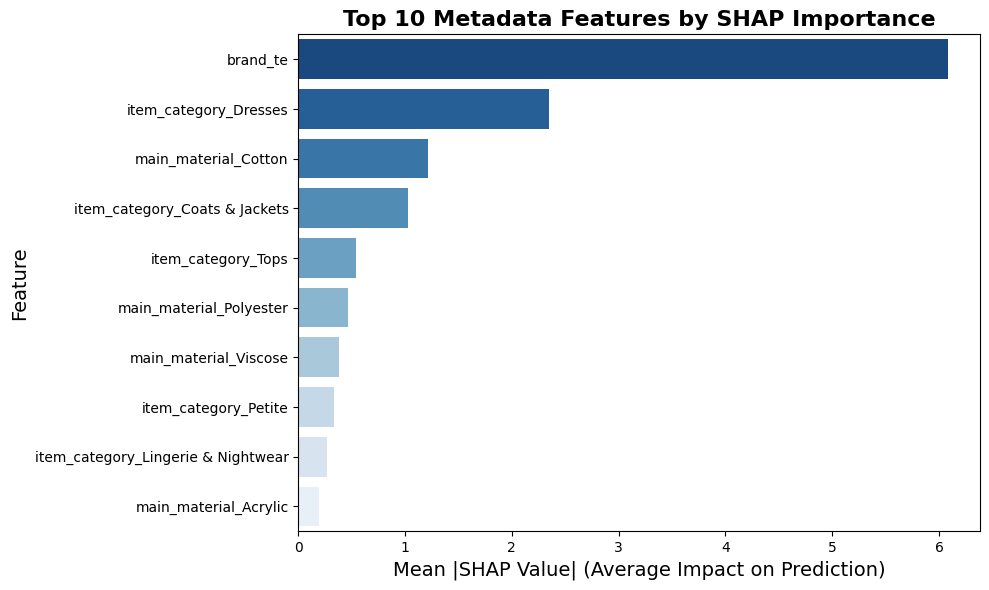

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Build DataFrame of metadata features and SHAP values
meta_ranked = pd.DataFrame({
    "feature": meta_cols,              # metadata feature names from notebook
    "mean_abs_shap": meta_importance   # mean(|SHAP|) for each metadata feature
}).sort_values("mean_abs_shap", ascending=False)

# Select Top 10 metadata features
top_k = 10
top_meta = meta_ranked.head(top_k)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_meta,
    x="mean_abs_shap",
    y="feature",
    palette="Blues_r"
)

plt.title("Top 10 Metadata Features by SHAP Importance", fontsize=16, weight="bold")
plt.xlabel("Mean |SHAP Value| (Average Impact on Prediction)", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
#Mispriced Items: Residual Analysis

y_pred = mlp_meta_bert.predict(X_test_meta_bert)

test_idx = y_test.index
test_df = df3.loc[test_idx].copy()

test_df["y_true"] = y_test.values
test_df["y_pred"] = y_pred
test_df["residual"] = test_df["y_true"] - test_df["y_pred"]
test_df["abs_residual"] = np.abs(test_df["residual"])

# Z-scores
resid_std = test_df["residual"].std()
test_df["z_score"] = test_df["residual"] / resid_std

# Identify mispriced items
underpriced = test_df[test_df["z_score"] > 2].sort_values("z_score", ascending=False)
overpriced = test_df[test_df["z_score"] < -2].sort_values("z_score")

cols = ["sku","brand","item_category","main_material","color_simple",
        "fit_type","y_true","y_pred","residual","z_score","description"]

print("=== Underpriced Items (>2 SD) ===")
display(underpriced[cols].head(10))

print("\n=== Overpriced Items (<-2 SD) ===")
display(overpriced[cols].head(10))


=== Underpriced Items (>2 SD) ===


,sku,brand,item_category,main_material,color_simple,fit_type,y_true,y_pred,residual,z_score,description
2564,115068795,The North Face,Jackets,Nylon,Black,NaN,300.0,131.282357,168.717643,9.626100,Jackets by The North Face
15513,120535176,ASOS Curve,Dresses,Polyester,Black,Regular,210.0,53.069527,156.930473,8.953589,Dresses by ASOS Curve All other dresses can go...
28869,120518806,Fiorucci,Jeans,Cotton,Blue,NaN,250.0,98.167426,151.832574,8.662731,Jeans by Fiorucci Part of a co-ord set Jacket ...
573,2031530,The North Face That powder-fresh aesthetic Adj...,Ski jacket,Nylon,Multi/Pattern,Regular,380.0,244.667163,135.332837,7.721346,Ski jacket by The North Face That powder-fresh...
1843,123578711,Barbour,Coats & Jackets,Polyamide,Multi/Pattern,Regular,329.0,202.578335,126.421665,7.212924,Coats & Jackets by Barbour Jacket upgrade: che...
873,123276247,Barbour,Coats & Jackets,Polyamide,Orange,Regular,289.0,166.768611,122.231389,6.973850,"Coats & Jackets by Barbour Throw on, go out Fi..."
15991,119616100,All,Dresses,Polyester,Black,Regular,249.0,128.396237,120.603763,6.880987,Dresses by All Saints All other dresses can go...
9951,103248712,ASOS Curve,Dresses,Polyester,White,Regular,195.0,74.658507,120.341493,6.866023,Dresses by ASOS Curve This dress + you = perfe...
21574,115955084,ASOS EDITION,Dresses,Polyester,Pink,NaN,250.0,130.388266,119.611734,6.824387,Dresses by ASOS EDITION Most grammable Crew ne...
15717,118728458,ASOS DESIGN,Dresses,Polyester,Beige,Regular,165.0,51.857612,113.142388,6.455282,"Dresses by ASOS DESIGN Dramatic entrance, sort..."



=== Overpriced Items (<-2 SD) ===


,sku,brand,item_category,main_material,color_simple,fit_type,y_true,y_pred,residual,z_score,description
2095,120561492,The North Face,Coats & Jackets,Polyester,Brown,NaN,45.0,187.669617,-142.669617,-8.139943,Coats & Jackets by The North Face Mid-season l...
2249,115388418,Reclaimed Vintage Exclusive to ASOS V-neck But...,Waistcoat,Leather,Beige,Regular,45.5,154.529033,-109.029033,-6.220596,Waistcoat by Reclaimed Vintage Exclusive to AS...
1550,123344245,Roxy,Coats & Jackets,Polyester,Black,Regular,136.0,232.426193,-96.426193,-5.501548,Coats & Jackets by Roxy That powder-fresh aest...
12203,119654761,Starlet,Dresses,Polyester,Black,Slim,57.0,148.088136,-91.088136,-5.196987,Dresses by Starlet Exclusive to ASOS Bandeau s...
2161,113918415,Berghaus,Jacket,Polyamide,Blue,Regular,48.0,126.706610,-78.706610,-4.490566,Jacket by Berghaus Love at first scroll Packs ...
2171,115068832,The North Face,Jacket,Nylon,Blue,Regular,46.5,125.177130,-78.677130,-4.488884,Jacket by The North Face This jacket on repeat...
16914,112488592,ASOS DESIGN Treats for your top drawer,Suspender,Polyamide,Black,NaN,7.0,84.528210,-77.528210,-4.423333,Suspender by ASOS DESIGN Treats for your top d...
14134,119904278,Whistles,Dresses,Lyocell,Multi/Pattern,Slim,99.0,174.471316,-75.471316,-4.305978,Dresses by Whistles Love at first scroll Flora...
1349,120561517,The North Face,Coats & Jackets,Polyester,Black,NaN,150.5,223.603466,-73.103466,-4.170881,Coats & Jackets by The North Face No chill Pac...
9859,120684495,ASOS EDITION,Dresses,Polyester,Grey,NaN,128.0,199.966269,-71.966269,-4.105999,Dresses by ASOS EDITION More is more Bead and ...


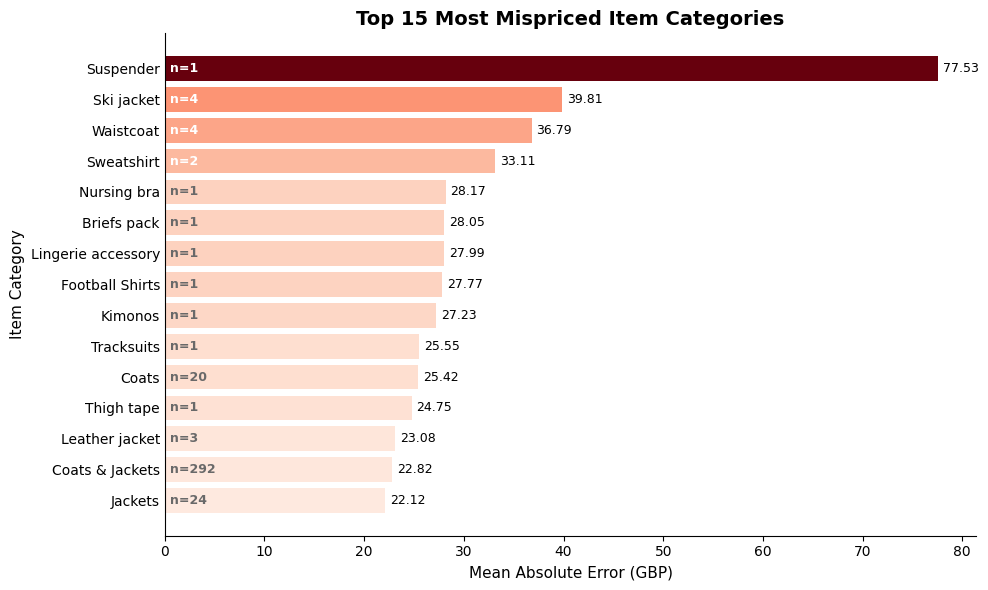

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# 1. Aggregate data: Mean Absolute Error and Count per Category
category_stats = test_df.groupby('item_category')['abs_residual'].agg(['mean', 'count'])
category_stats.columns = ['mean_error', 'count']

# 2. Select Top 15 categories with the highest mean error
top_mispriced = category_stats.sort_values('mean_error', ascending=True).tail(15)

# 3. Setup Colors (Dark Red for high error -> Light for low error)
# We normalize the error values to map them to the 'Reds' colormap
norm = mcolors.Normalize(vmin=top_mispriced['mean_error'].min() * 0.8, vmax=top_mispriced['mean_error'].max())
cmap = plt.cm.Reds
bar_colors = [cmap(norm(val)) for val in top_mispriced['mean_error']]

# 4. Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_mispriced.index, top_mispriced['mean_error'], color=bar_colors, edgecolor='none')

for bar, count, value in zip(bars, top_mispriced['count'], top_mispriced['mean_error']):
    text_color = 'white' if value > 30 else 'dimgrey'
    font_weight = 'bold'

    # Add Count Label (n=...) inside the bar
    ax.text(0.5, bar.get_y() + bar.get_height()/2,
            f"n={count}",
            va='center', ha='left',
            color=text_color, fontweight=font_weight, fontsize=9)

    # Add Value Label at the end of the bar
    ax.text(value + 0.5, bar.get_y() + bar.get_height()/2,
            f"{value:.2f}",
            va='center', ha='left',
            color='black', fontsize=9)

# 6. Formatting
ax.set_title("Top 15 Most Mispriced Item Categories", fontsize=14, fontweight='bold')
ax.set_xlabel("Mean Absolute Error (GBP)", fontsize=11)
ax.set_ylabel("Item Category", fontsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='y', length=0) # Hide y-axis ticks for cleaner look

plt.tight_layout()
plt.show()